
# Project: Which countries produce the most carbon per capita? 

How does this change by continent? Where is it increasing and descreasing at the fastest rate?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

## Introduction

An article a few months back in the Guardian caught my eye. It reported a study that, contrary to popular wisdom, the key changes an individual can make to reduce their carbon footprint:

* have one less child than planned
* forego driving
* eliminate meat
* reduce long-haul air travel

For this project, I'd explore some Gapminder to see for the relationships for myself, and how it varies over the world. 

Since Gapminder doesn't have data on air travel or meat consumption, I will be focusing mainly on fertility and vehicle/road data.

Also, to make sure we're comparing apples to apples, I will add region and sub-region data, and try to break along levels of health and well-being.


## About the data

Average CO2 *(or CO?)* emission in metric tons per person during the given year, calculated from converting C to CO2 (C * 3.67), then dividing the total population of the countries.

https://docs.google.com/spreadsheets/d/1RjqGm7RG82GGVf7E4RXPPwFF7O1So6T0SFx2fVfcUJA/pub?range=A1:D70&gid=1&output=html#

* `country`, `year`, `CO2`: Pre-1950, based on historical calculations that tabulate coal, brown coal, peat, and crude oil production by nation and year. 1950 onwards, Fossil-Fuel Burning (liquid, gas & solid), Cement Manufacture, and Gas Flaring.
http://cdiac.ess-dive.lbl.gov/trends/emis/meth_reg.html

* region & sub-region: These lists are the result of merging data from two sources, the Wikipedia ISO 3166-1 article for alpha and numeric country codes, and the UN Statistics site for countries' regional, and sub-regional codes. In addition to countries, it includes dependent territories. https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes

* energy: Energy use refers to use of primary energy before transformation to other end-use fuels, which is equal to indigenous production plus imports and stock changes, minus exports and fuels supplied to ships and aircraft engaged in international transport. https://data.worldbank.org/indicator/EG.USE.PCAP.KG.OE

* hdi: A composite index measuring average achievement in three basic dimensions of human developmentóa long and healthy life, knowledge and a decent standard of living. See Technical note 1 at http://hdr.undp.org/. http://hdr.undp.org/en/indicators/137506

* income: GDP per capita measures the value of everything produced in a country during a year, divided by the number of people. The unit is in international dollars, fixed 2011 prices. The data is adjusted for inflation and differences in the cost of living between countries, so-called PPP dollars. https://www.gapminder.org/data/documentation/gd001/

* motor - no longer available on world bank!

* population: We use UN population data between 1950 to 2100 from UN Population Division World Population Prospects 2017 and the forecast to year 2100 is using their medium fertility variant. For years before 1950, this version uses the data documented in greater detail by Mattias Lindgren in version 3 below. The main source there was Angus Maddison’s data which is maintained and improved by CLIO Infra Project.https://www.gapminder.org/data/documentation/gd003/

* roads: drop?

* sulfur: Human emission of sulfur. Emissions from shipping is not included.	Units in Kilogram sulfur emission per person and year. https://docs.google.com/spreadsheets/d/1wnhRtOy-WB5g8LRv5cpuWg3q268ahuEJTHvxt9VfvLM/pub?range=A1:D70&gid=1&output=html#

* surviving: How many children per woman that survive up to the age of 35.	https://docs.google.com/spreadsheets/d/16OAUB-nZVgpdhN-CBnklLztkxreJtXqh1bwgJEk6yg0/pub?range=A1:D70&gid=1&output=html#


# Load data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp
%matplotlib inline

# to use seaborn styling
sns.set()

# to display interactive plots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# for data wrangling involved 
#to create final_df.csv, see make_df.ipynb
df = pd.read_csv('data/final/final_df.csv')
df.head()

df.tail()

df.info()

# avoid headaches when using df.query: remove '-' from sub-region col!
df.rename(columns={'sub-region':'sub_region'}, inplace=True)

# verify name change
df.head()

df['CO2'].describe()

# Data Exploration

## What does the `CO2` look like?

value = 'CO2'
df[value].hist(bins=50); 

This is not very useful. Also, since CO2 data can go back to the 1700s, it's not all that relevant. Let's reduce the timeframe.

# CO2 dist since 1950

query = 'year >= 1950'

df.query(query)[value].hist(bins=50)
plt.title('Distribution of %s for %s' % (value, query)); 

Interestingly, the range of CO2 emissions has decreased. I suspect this is because coal is no longer a main fuel source. Something to dig into later.

### How does this distribution vary by region?

# dist by region

df.query(query).sort_values('region').set_index(['region', 'sub_region','country','year']).\
unstack(level=(0))[value].hist( figsize=(6,6));



#### Europe has the only normal-ish distribution
Negative-skew data, except for Europe which is almost normal. Asia has an exceptionally long tail.

### What about outliers?

I can barely make out the long tails in these histograms. Boxplots will highlight where there are outliers.


# set style for showing outliers
flierprops = dict(marker='o', markersize=5, alpha=0.2)

# reshape so region, sub_region & CO2 are columns
df_box = df.query(query).sort_values(['region', 'sub_region']).\
set_index(['region', 'sub_region','country','year'])['CO2'].reset_index(level=(0,1))
                                                                        
df_box.boxplot(by='region', flierprops = flierprops);

#### Positive outliers everywhere especially in Asia

So which sub-regions are represented by these outliers?

# make boxplot subplots

# split reshaped into smaller regional df's
regions_dfs = [df_box.loc[df_box['region']==region] for region in df_box['region'].unique()]

def make_regional_boxplot(df):
    df.boxplot(by='sub_region', flierprops = flierprops, rot=45)
    plt.title(df['region'].unique())
    plt.show();

p = pd.Series(regions_dfs).apply(make_regional_boxplot)
p;

## ALTERNATIVE - use matplotlib subplots?
#fig, axes = plt.subplots(nrows=3, ncols=2)

#df1.plot(ax=axes[0,0])
#df2.plot(ax=axes[0,1])

#### Eastern Europe is only sub_region with negative outliers

Everywhere else, there are only postive outliers. 
The most extreme outliers seem to be in Western Asia, probably from the oil-rich countries.

Let's create some interactive charts to look at the regions in more detail.

### What does this look like over time?

#### Pandas plotting

def reshape_for_pandas_faceting(df, region, value):
    
    # create multi-index and limit df to Europe
    df_region = df.reset_index().set_index(['region', 'sub_region', 'country']).loc[region]

    # transpose df & unstack years columns into single column
    df_region = pd.DataFrame(df_region.T.unstack()).reset_index().rename(columns={'level_2':'year', 0: value})

    return df_region

def pandas_subregion_plot(df, region, value):
    # subset df by region 
    df = df.loc[df['region']==region].copy()
    
    # create spaghetti plot of countries by sub_region
    for subreg in df['sub_region'].unique():
        df.loc[df['sub_region']==subreg].pivot('year', 'country', value).plot()
        plt.title(subreg + ' ' + value)
        
        # Put a legend to the right of the current axis
        plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

# plot
query = 'year >= 1950'
region = 'Europe'
value = 'CO2'

pandas_subregion_plot(df, region, value)

#### Observations

##### What's with Luxembourg & Gibraltar? 

How can tiny countries known for financial services produce so much per capita CO2? 
Similarly, what's going on in the Faroe Islands, another tiny country that's a bit of an outlier for CO2 emissions.

##### Lots of noise in the north & south

Even after faceting by sub_region, the N. & S. Europe plots are noisy. E. Europe, made up of entirely of former USSR states, all follow the same pattern. However, some ex-Soviet countries are included instead in either Northern or Southern Europe, which may account for the noisiness. 

##### Weird sub_region composition

Also, some of the sub_region compositions surprised me: for example, putting 'United Kingdom' with Northern instead of Western Europe.

#### Plotly + cufflinks plotting

# create an interactive plotting function
import plotly as py
import cufflinks as cf
import plotly.tools as tls
tls.embed('https://plot.ly/~cufflinks/8')

cf.set_config_file(offline=True, world_readable=False, theme='ggplot')

#co2_long = reshape_for_facet_plot(co2_regions, 'Europe')
#co2_eur = reshape_for_pandas_faceting(co2_regions, region, value)

def plotly_line(df, title):
    fig = df.iplot(asFigure = True,\
                    title = title,\
                    yTitle = str.title("Whatever"),\
                    theme = 'ggplot')
    return fig

def plotly_subreg_timeseries(df, subplot, value):
    for subreg in df[subplot].unique():
        subreg_df = df.loc[df[subplot]==subreg].pivot(index, column, value)
        #print subreg_df.head()
        fig = plotly_line(subreg_df, subreg + ' ' + value)
        py.offline.iplot(fig)

# plot
query = "region=='Europe' & year >= 1950"
subplot = 'sub_region'
index = 'year'
column = 'country'
value = 'CO2'

plotly_subreg_timeseries(df.query(query), subplot, value)

########## TO INTERACT WITH PLOT.LY PLOT #########
##### Hide a line: single-click corresponding legend item
##### Isolate a line: double-click legend item
##### Bring back all lines: double-click item a 2nd time
##### Select, zoom, pan: hover on upper right of plot to display toolbar

#### Observations

* The smallest countries tend to have highest avg CO2pc values, such as Luxembourg, Gibralter, Faroe Islands, Estonia and Andorra. 
* If you focus on these smaller countries, however, it looks like they have such high avergages because the history for their CO2 data is short. Better to compare sums, or take average since a recent year



# TO FIX
#for f in df[facet].unique():
        #f_df = df.loc[df[facet]==f].pivot(index, column, value)
        #print f_df.head()
        #fig = plotly_line(f_df, f + ' ' + value)
        #py.offline.iplot(fig)

## Where are the highest & lowest CO2 emissions in 2010?

# global max
df[['country', 'year', 'CO2']].loc[df.query('year==2010')['CO2'].idxmax()]

# regional max
df.query('year==2010').groupby('region').max()['CO2'].sort_values()

# global min
df[['country', 'year', 'CO2']].loc[df.query('year==2010')['CO2'].idxmin()]

# regional min
df.query('year==2010').groupby('region').min()['CO2'].sort_values()

## Where are CO2 emissions changing the most in last 10 years?

In [182]:
# reshape df so region/countries are columns, and years are the rows
# then calculate 10 yr % change entire DF

co2_change = df.sort_values(['region', 'sub_region']).set_index(['region','sub_region','country','year']).\
unstack(level=(0,1,2))['CO2'].pct_change(10)

# verify
co2_change.tail()

region             Africa                                                    \
sub_region Eastern Africa                                                     
country           Burundi   Comoros  Djibouti   Eritrea  Ethiopia     Kenya   
year                                                                          
2008            -0.350282  0.301776  0.028041 -0.513661 -0.008488 -0.211970   
2009            -0.528967  0.182914 -0.022221 -0.424784  0.032234 -0.062772   
2010            -0.221050  0.264779  0.100604 -0.411243 -0.119428 -0.079739   
2011                  NaN       NaN       NaN       NaN       NaN       NaN   
2012                  NaN       NaN       NaN       NaN       NaN       NaN   

region                                                     ...         \
sub_region                                                 ...          
country    Madagascar    Malawi Mauritius Mozambique       ...          
year                                                       ...          
2008        -0.174491  0.056154  0.644913   0.599008       ...          
2009        -0.299453 -0.196464  0.436212   0.681117       ...          
2010        -0.203101  0.031195  0.369327   0.661948       ...          
2011              NaN       NaN       NaN        NaN       ...          
2012              NaN       NaN       NaN        NaN       ...          

region        Oceania                                                 \
sub_region Micronesia                                                  
country      Kiribati Marshall Islands Micronesia Fed Sts      Nauru   
year                                                                   
2008         0.399968         0.395523            0.196559 -0.259136   
2009         0.157543         0.517217           -0.182468 -0.245796   
2010         0.594093         0.286625           -0.270232 -0.195713   
2011              NaN              NaN                 NaN       NaN   
2012              NaN              NaN                 NaN       NaN   

region                                                               \
sub_region                  Polynesia                                 
country        Palau French Polynesia      Niue     Samoa     Tonga   
year                                                                  
2008        0.631022         0.267360  1.586495  0.166654  0.381953   
2009        0.652555         0.305877  1.585043  0.111985  0.263883   
2010        0.726669         0.229741  1.588556  0.116583  0.226357   
2011             NaN              NaN       NaN       NaN       NaN   
2012             NaN              NaN       NaN       NaN       NaN   

region                       
sub_region                   
country    Wallis et Futuna  
year                         
2008                    NaN  
2009                    NaN  
2010                    NaN  
2011                    NaN  
2012                    NaN  

[5 rows x 201 columns]

In [183]:
# get max change % for each region
pd.DataFrame(co2_change.loc[2010]).unstack(level=(0)).max(axis=0)

      region  
2010  Africa      6.645446
      Americas    4.412812
      Asia        6.672627
      Europe      0.588548
      Oceania     1.588556
dtype: float64

In [184]:
# what's the minumum change %?
pd.DataFrame(co2_change.loc[2010]).unstack(level=0).min(axis=0).sort_values()

      region  
2010  Asia       -0.787415
      Americas   -0.508262
      Africa     -0.411243
      Oceania    -0.270232
      Europe     -0.249033
dtype: float64

In [185]:
# what's the min change % for each sub_region?
pd.DataFrame(co2_change.loc[2010]).unstack(level=(0,1)).min(axis=0)

      region    sub_region               
2010  Africa    Eastern Africa              -0.411243
                Middle Africa                0.388994
                Northern Africa             -0.405580
                Southern Africa             -0.227627
                Western Africa              -0.281926
      Americas  Caribbean                   -0.346666
                Central America             -0.508262
                Northern America            -0.158079
                South America               -0.126119
      Asia      Central Asia                -0.213964
                Eastern Asia                -0.499508
                South-Eastern Asia          -0.787415
                Southern Asia               -0.061463
                Western Asia                -0.398719
      Europe    Eastern Europe              -0.096195
                Northern Europe             -0.203478
                Southern Europe             -0.249033
                Western Europe          

## Who has the biggest CO footprint?

China? The US? Let's see.

In [186]:
footprint = df['CO2'] * df['population']
df['CO2_footprint'] = footprint
df[['country','CO2', 'population', 'CO2_footprint']].loc[df.query('year >= 2010')['CO2_footprint'].idxmax()]

country                China
CO2                  7.11264
population       1.35539e+09
CO2_footprint    9.64038e+09
Name: 3007, dtype: object

In [187]:
# plot CO2 by population
df.query('year == 2010').iplot(kind='bubble', x='population', y='CO2', size='CO2_footprint', text='country',\
           xTitle='Population', yTitle='CO2 per capita', categories='region', logx=True,\
             title='Who had the biggest CO2 footprint in 2010?')

## What are the correlations?

Time to look at correlations with other measurements

In [188]:
# global correlations
df_from_1990.corr()['CO2'].sort_values(ascending=False)

CO2           1.000000
energy        0.916861
income        0.833363
motor         0.628480
hdi           0.563759
roads         0.443501
sulfur        0.067741
year          0.046228
population   -0.033980
surviving    -0.372665
Name: CO2, dtype: float64

In [189]:
# correlations by region
df_from_1990.groupby('region').corr()['CO2'].unstack().T\
.drop('year')

region,Africa,Americas,Asia,Europe,Oceania
CO2,1.000000,1.000000,1.000000,1.000000,1.000000
energy,0.942664,0.984029,0.970059,0.619260,0.943659
hdi,0.671373,0.601001,0.576096,0.404073,0.795858
income,0.828313,0.813016,0.871435,0.634809,0.855650
motor,0.857026,0.788417,0.689550,0.496686,0.755291
population,0.023331,0.176212,-0.142034,0.142316,0.639903
roads,0.430849,0.391329,0.293498,0.226347,0.522866
sulfur,0.319620,0.378102,0.035405,0.101233,0.948398
surviving,-0.473921,-0.497992,-0.062861,0.041379,-0.831467


### Observations

#### Energy, then Income have highest correlation with CO2 p.c. emissions

Motor vehicle ownership & HDI also show strong correlations. 
Kids surviving to 35 have a moderate negative correlation overall, and a strong negative correlation for Oceania.

Another exception for Oceania is sulfur emissions: it has the highest correlation with CO2 emissions for Oceania, whereas it is small everwhere else.

But to what extent are HDI, vehicle ownership, and surviving kids (i.e. family size) just proxies for income? 

## Is there a lot of variation in correlations within regions?

In [190]:
# further break down CO2 correlation matrix by sub_region
co2_corr = df_from_1990.groupby(['region', 'sub_region']).corr()[value]
co2_corr = co2_corr.unstack(level=(0,1))

co2_corr

region             Africa                                                \
sub_region Eastern Africa Middle Africa Northern Africa Southern Africa   
CO2              1.000000      1.000000        1.000000        1.000000   
energy           0.926400      0.796404        0.960916        0.994348   
hdi              0.709926      0.482005        0.730679        0.691427   
income           0.911207      0.844048        0.981169        0.641358   
motor            0.831323      0.806255        0.986523        0.932171   
population      -0.336111     -0.280745       -0.239193        0.973493   
roads            0.679899     -0.126191        0.125965        0.130907   
sulfur           0.063761      0.851480        0.928677        0.026853   
surviving       -0.777096     -0.157202       -0.144520       -0.496047   
year             0.112771      0.175058        0.058804        0.067401   

region                     Americas                                   \
sub_region Western Africa Caribbean Central America Northern America   
CO2              1.000000  1.000000        1.000000         1.000000   
energy           0.436882  0.977699        0.978531         0.161856   
hdi              0.550812  0.366518        0.682009         0.032505   
income           0.689246  0.650854        0.877457         0.448199   
motor            0.704563  0.573812        0.790490         0.863726   
population       0.258495 -0.240418        0.852715         0.768042   
roads            0.299943  0.080682        0.641754         0.955545   
sulfur           0.642194  0.201592        0.925101        -0.763605   
surviving       -0.165127 -0.440006       -0.466277         0.774235   
year             0.015124  0.090433        0.184031         0.039383   

region                           Asia    ...                                \
sub_region South America Central Asia    ...    Southern Asia Western Asia   
CO2             1.000000     1.000000    ...         1.000000     1.000000   
energy          0.939131     0.963804    ...         0.988994     0.970888   
hdi             0.491993     0.904930    ...         0.628671     0.543058   
income          0.696495     0.894265    ...         0.932869     0.891493   
motor           0.680661     0.901004    ...        -0.149867     0.695221   
population     -0.130278     0.062327    ...        -0.003728    -0.272182   
roads           0.750426     0.038141    ...         0.347483     0.072519   
sulfur          0.193295     0.701361    ...         0.877116    -0.011885   
surviving      -0.311444    -0.708944    ...        -0.446998     0.020645   
year            0.065902     0.191970    ...         0.213621     0.033718   

region             Europe                                                 \
sub_region Eastern Europe Northern Europe Southern Europe Western Europe   
CO2              1.000000        1.000000        1.000000       1.000000   
energy           0.929065        0.133157        0.827620       0.959032   
hdi              0.336084        0.246928        0.773237      -0.227065   
income           0.412894        0.329888        0.727295       0.689890   
motor            0.537834        0.233756        0.700437       0.478472   
population       0.753646       -0.026896        0.165765      -0.295947   
roads            0.055706        0.272815        0.782286      -0.000845   
sulfur           0.308208        0.578316        0.479909       0.499301   
surviving        0.043426        0.330538       -0.685504       0.091608   
year            -0.190033       -0.070834        0.204260      -0.139530   

region                       Oceania                                 
sub_region Australia and New Zealand Melanesia Micronesia Polynesia  
CO2                         1.000000  1.000000   1.000000  1.000000  
energy                      0.970022  0.961708   0.980294  0.984651  
hdi                         0.566742  0.779061   0.972859  0.724718  
income                      0.6286

### Observations
#### In North America, Family Size (Surviving Kids) has a positive correlation

There are fascinating descrepancies within the regions as well.

For example, North America is the only sub_region in the world where the more adult children in a family, the higher the per capita CO2 emissions.

Another unique exception in N. America: Energy has an exceptionally low correlation. But the correlation with motor vehicle ownership & % roads paved is the highest in the Americas.

In [197]:
# investigate wierd correlations with Energy
query = "sub_region=='Northern America' & year >=1990"
x = 'energy'
y = 'CO2'
size = 'CO2_footprint'
cat_col = 'country'

df.query(query).iplot(kind='scatter', x=x, y=y, text='year',\
           xTitle=str.title(x), yTitle=str.title(y), categories=cat_col, logx=True,\
             title='Why does N. America have such a low energy correlation?')

### Blame it on Canada!

Increasing use of Hydro electricity? Switch from oil to natural gas?

In [199]:
# investigate wierd correlations with Surviving Kids
#query = "sub_region=='Northern America' & year >=1990"
x = 'surviving'
y = 'CO2'
size = 'CO2_footprint'
cat_col = 'country'

df.query(query).iplot(kind='scatter', x=x, y=y, text='year',\
           xTitle=str.title(x), yTitle=str.title(y), categories=cat_col, logx=True,\
             title='Why does N. America have such a high surviving correlation?')

## Are the regional breakdowns too arbitrary?

In some regions, there are 'gorillas' that could skew the numbers, such as the US in the Americas, or Australia for Oceania.

Looking at the bubble plots, in each region there seems to be an invisible line dividing a few high-income/energy/CO2 emitting countries from the mass of countries clustered in the bottom left.

In other words, do the 'have' countries emit CO2 for different reasons than the have-not countries, regardless of where they are located?

In [202]:
# compare income to surviving kids by HDI level
query = 'year == 2008'
x = 'income'
y = 'surviving'
size = 'CO2_footprint'
cat_col = 'hdi'

plot_bubble_with_cuts(df.query(query), cat_col)

#### Observations

This curve of this plot makes me think of the Big Dipper.

Unlike the other HDI categories, very high HDI countries (i.e. 'The West' + Oil-producing Asian countries) tend to have more children as their income increases, at least beyond 30k a year.





In [203]:
# which countries have the highest hdi?
hdi_ww_ranked = df.query('year >=1990').groupby('country').mean().sort_values('hdi', ascending=False)['hdi']

# create groups based on mean hdi
hdi_groups = np.split(hdi_ww_ranked.index, 3)
top_hdi, mid_hdi, bottom_hdi = hdi_groups

In [204]:
# top
df.loc[df['country'].isin(top_hdi.values)].corr()[value].sort_values(ascending=False)

CO2              1.000000
energy           0.755274
income           0.666053
year             0.375697
motor            0.295287
sulfur           0.223370
CO2_footprint    0.156243
roads            0.152476
hdi              0.138996
surviving        0.138548
population       0.079752
Name: CO2, dtype: float64

In [205]:
# mid
df.loc[df['country'].isin(mid_hdi.values)].corr()[value].sort_values(ascending=False)

CO2              1.000000
energy           0.934860
income           0.701003
hdi              0.425593
sulfur           0.410138
motor            0.382368
year             0.374080
roads            0.324986
CO2_footprint    0.194935
population       0.027502
surviving       -0.156212
Name: CO2, dtype: float64

In [206]:
# bottom
df.loc[df['country'].isin(bottom_hdi.values)].corr()[value].sort_values(ascending=False)

CO2              1.000000
energy           0.900885
motor            0.873307
income           0.840377
hdi              0.430753
sulfur           0.299459
roads            0.233646
year             0.218992
surviving        0.199495
CO2_footprint    0.127071
population      -0.185104
Name: CO2, dtype: float64

In [207]:
top_df = df.query('country in @top_hdi')
top_df.head()

,country,region,sub_region,year,CO2,energy,hdi,income,motor,population,roads,sulfur,surviving,CO2_footprint
243,Andorra,Europe,Southern Europe,1995,6.290669,NaN,NaN,26100.0,NaN,63854.0,NaN,NaN,NaN,401684.384609
244,Andorra,Europe,Southern Europe,1996,6.520817,NaN,NaN,27200.0,NaN,64291.0,NaN,NaN,NaN,419229.848582
245,Andorra,Europe,Southern Europe,1997,7.061603,NaN,NaN,29700.0,NaN,64147.0,NaN,NaN,NaN,452980.638372
246,Andorra,Europe,Southern Europe,1998,7.533543,NaN,NaN,30800.0,NaN,63888.0,NaN,NaN,NaN,481302.991625
247,Andorra,Europe,Southern Europe,1999,8.022714,NaN,NaN,31900.0,NaN,64161.0,NaN,NaN,NaN,514745.330934


In [208]:
top_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6797 entries, 243 to 14581
Data columns (total 14 columns):
country          6797 non-null object
region           6797 non-null object
sub_region       6797 non-null object
year             6797 non-null int64
CO2              6797 non-null float64
energy           2434 non-null float64
hdi              1305 non-null float64
income           6734 non-null float64
motor            221 non-null float64
population       3822 non-null float64
roads            805 non-null float64
sulfur           5432 non-null float64
surviving        6494 non-null float64
CO2_footprint    3822 non-null float64
dtypes: float64(10), int64(1), object(3)
memory usage: 796.5+ KB


In [209]:
df.query(query).tail()

,country,region,sub_region,year,CO2,energy,hdi,income,motor,population,roads,sulfur,surviving,CO2_footprint
14873,Wallis et Futuna,Oceania,Polynesia,2008,1.589251,NaN,NaN,NaN,NaN,13841.0,NaN,NaN,NaN,2.199682e+04
14887,West Bank and Gaza,Asia,Western Asia,2008,0.536602,NaN,NaN,NaN,NaN,3854667.0,NaN,NaN,NaN,2.068423e+06
14928,Western Sahara,Africa,Northern Africa,2008,0.479618,NaN,NaN,NaN,NaN,483167.0,NaN,NaN,NaN,2.317357e+05
14975,Zambia,Africa,Eastern Africa,2008,0.148982,0.617251,0.518,2880.0,NaN,13114579.0,NaN,NaN,4.12,1.953830e+06
15069,Zimbabwe,Africa,Eastern Africa,2008,0.654323,0.744783,0.419,1210.0,NaN,13495462.0,NaN,NaN,2.28,8.830394e+06


In [210]:
query = 'year == 2010 & country in @top_hdi'

df.query(query).iplot(kind='bubble', x='CO2', y='income', size='population', text='country',\
       xTitle='Carbon Emissions per capita', yTitle='Income per capita', categories='region',\
         title='Carbon Emissions vs Income per capita for %s' % query)

In [211]:
df.query('year==2010').iplot(kind='bubble', x='CO2', y='energy', size='population', text='country',\
       xTitle='Carbon Emissions per capita', yTitle='Energy per capita', categories='region',\
         title='Carbon vs Energy Consumption per capita 2010')

### Nothing really newsworthy here

So far, we've ascertained that income and energy have a positive correlation with CO2 p.c. emissions. 

There is pretty clear-cut segmentation when you break it down by income or HDI levels, instead of regions.

None of this is new. Let's look at something more interesting. Where has CO2 p.c. been *decreasing*, and what has been decreasing along with it? 

## Where have CO2 emissions been going down?

The worldwide trend has been up. Who are bucking the trend? Can we guess at possible causes by looking at correlations. (Yes, I know, correlation does NOT mean causation).

Let's look at the 10-year change rates again, this time focusing on the 10-year period ending 2008, so we avoid the income/GDP hit caused by the 2008 financial crash.

In [212]:
# for each region, show the 5 countries with the biggest 10-yr decrease 
# in CO2 p.c. emissions
for region in df['region'].unique():
    print co2_change.loc[2008, [region]].sort_values().head()
    print '\n'

region  sub_region          country    
Asia    South-Eastern Asia  Singapore     -0.729865
        Eastern Asia        Macao China   -0.387189
        Western Asia        Bahrain       -0.233088
                            Qatar         -0.174995
        Southern Asia       Bhutan        -0.155952
Name: 2008, dtype: float64


region  sub_region       country
Europe  Northern Europe  Denmark   -0.192574
        Western Europe   Belgium   -0.167320
                         France    -0.142126
        Southern Europe  Andorra   -0.133576
        Eastern Europe   Moldova   -0.115804
Name: 2008, dtype: float64


region  sub_region       country       
Africa  Eastern Africa   Eritrea          -0.513661
                         Zimbabwe         -0.437065
                         Rwanda           -0.412966
        Western Africa   Niger            -0.398549
        Northern Africa  Western Sahara   -0.387614
Name: 2008, dtype: float64


region    sub_region        country      
Americas  Car

Hmmmm...let's instead compare HDI buckets.

### Compare correlations for high, med, low HDI

In [213]:
df_hdi_levels = cut_column(df, 'hdi')

### High HDI

In [214]:
query = "hdi_level in ['3 high hdi', '4 very high hdi']"

hdi_2008_high = df_hdi_levels.query(query).sort_values(['region', 'sub_region'])\
.set_index(['region','sub_region','country','year']).\
unstack(level=(0,1,2))\
['CO2'].pct_change(10).loc[2008].sort_values().head()


In [215]:
query = 'year >= 1998 & year < 2008 & country in @countries'
countries = hdi_2008_high.reset_index()['country']
countries

0     Singapore
1    Tajikistan
2       Bahrain
3         Gabon
4      Paraguay
Name: country, dtype: object

In [216]:
# correlations for high HDI countries 1998-2008

df.query(query).set_index('year').\
drop(['country', 'region', 'sub_region', 'CO2_footprint', 'population'], axis=1).\
corr()['CO2'].sort_values(ascending=False)

CO2          1.000000
energy       0.954103
motor        0.953134
sulfur       0.934658
hdi          0.731752
income       0.687218
roads        0.446382
surviving   -0.430878
Name: CO2, dtype: float64

In [217]:
# correlations for each country

for country in countries:
    print str.upper(country)
    print df.query(query).loc[df.query(query)['country']==country].set_index('year').\
    drop(['country', 'region', 'sub_region', 'CO2_footprint', 'population'], axis=1).\
    corr()['CO2'].sort_values(ascending=False)
    print '\n'

SINGAPORE
CO2          1.000000
sulfur       0.999901
surviving    0.812335
energy      -0.395416
motor       -0.763747
hdi         -0.798910
income      -0.942331
roads             NaN
Name: CO2, dtype: float64


TAJIKISTAN
CO2          1.000000
sulfur       0.999636
energy       0.938214
income       0.325935
hdi          0.306366
surviving   -0.218700
motor             NaN
roads             NaN
Name: CO2, dtype: float64


BAHRAIN
CO2          1.000000
surviving    0.702012
income       0.674921
sulfur       0.480998
roads       -0.174426
energy      -0.337093
hdi         -0.597355
motor       -0.650763
Name: CO2, dtype: float64


GABON
CO2          1.000000
sulfur       0.999821
energy       0.842337
hdi          0.753198
roads        0.732223
income      -0.200172
surviving   -0.431603
motor             NaN
Name: CO2, dtype: float64


PARAGUAY
CO2          1.000000
energy       0.955348
surviving    0.787451
sulfur       0.488805
income       0.444178
hdi         -0.730201
motor   

#### Observations

For these high HDI countries, `surviving`  has an unusually high positive correlation with CO2.

Of note when looking at the correlations for each of the 5 countries seperately:

* Singapore & Bahrain have extremely high correlations for `surviving`
* 4 of the countries have high + correlations for `sulfur`, while Paraguay still has a moderate one.

Does this differ compared to low HDI countries?

### Low HDI

In [218]:
# low HDI countries

query = "hdi_level=='1 low hdi'"

hdi_2008_low = df_hdi_levels.query(query).sort_values(['region', 'sub_region'])\
.set_index(['region','sub_region','country','year']).\
unstack(level=(0,1,2))\
['CO2'].pct_change(10).loc[2008].sort_values().head()

hdi_2008_low

region  sub_region      country     
Africa  Western Africa  Niger          -0.398549
        Eastern Africa  Burundi        -0.350282
        Western Africa  Guinea         -0.171345
                        Sierra Leone    0.536304
        Eastern Africa  Djibouti             NaN
Name: 2008, dtype: float64

In [219]:
# get low HDI countries with greatest decrease
countries = hdi_2008_low.reset_index()['country']

# drop Sierra Leone (positive change) & Djibouti (no value)
countries.drop([3,4], inplace=True)
countries

0      Niger
1    Burundi
2     Guinea
Name: country, dtype: object

In [220]:
# correlations for these countries 1998-2008
query = 'year >= 1998 & year < 2008 & country in @countries'

df.query(query).set_index('year').\
drop(['country', 'region', 'sub_region', 'CO2_footprint', 'population'], axis=1).\
corr()['CO2'].sort_values(ascending=False)

CO2          1.000000
income       0.914728
sulfur       0.770312
hdi          0.600576
surviving    0.147702
roads       -0.037387
motor       -0.974135
energy            NaN
Name: CO2, dtype: float64

In [221]:
# correlations for each country
for country in countries:
    print str.upper(country)
    print df.query(query).loc[df.query(query)['country']==country].set_index('year').\
    drop(['country', 'region', 'sub_region', 'CO2_footprint', 'population'], axis=1).\
    corr()['CO2'].sort_values(ascending=False)
    print '\n'

NIGER
CO2          1.000000
sulfur       0.940580
income       0.700627
roads        0.354087
surviving   -0.759888
hdi         -0.769782
energy            NaN
motor             NaN
Name: CO2, dtype: float64


BURUNDI
CO2          1.000000
surviving    0.898215
income       0.853179
sulfur       0.717587
hdi         -0.705978
roads       -0.999749
energy            NaN
motor             NaN
Name: CO2, dtype: float64


GUINEA
CO2          1.000000
surviving    0.637810
roads        0.201853
sulfur      -0.199327
income      -0.644993
hdi         -0.881010
energy            NaN
motor             NaN
Name: CO2, dtype: float64




### Medium HDI

In [222]:
query = "hdi_level=='2 med hdi'"

hdi_2008_medium = df_hdi_levels.query(query).sort_values(['region', 'sub_region'])\
.set_index(['region','sub_region','country','year']).\
unstack(level=(0,1,2))\
['CO2'].pct_change(10).loc[2008].sort_values().head()

hdi_2008_medium

region  sub_region       country      
Africa  Eastern Africa   Zimbabwe        -0.437065
                         Zambia          -0.376553
                         Kenya           -0.211970
        Southern Africa  Swaziland       -0.194895
        Western Africa   Cote d Ivoire   -0.168595
Name: 2008, dtype: float64

In [223]:
# get med HDI countries with greatest decrease
countries = hdi_2008_medium.reset_index()['country']
countries

0         Zimbabwe
1           Zambia
2            Kenya
3        Swaziland
4    Cote d Ivoire
Name: country, dtype: object

In [224]:
query = 'year >= 1998 & year < 2008 & country in @countries'

df.query(query).set_index('year').\
drop(['country', 'region', 'sub_region', 'CO2_footprint', 'population'], axis=1).\
corr()['CO2'].sort_values(ascending=False)

CO2          1.000000
motor        0.948606
roads        0.772635
income       0.578808
energy       0.460393
hdi          0.224638
sulfur      -0.457870
surviving   -0.856516
Name: CO2, dtype: float64

In [225]:
# correlations for each country
for country in countries:
    print str.upper(country)
    print df.query(query).loc[df.query(query)['country']==country].set_index('year').\
    drop(['country', 'region', 'sub_region', 'CO2_footprint', 'population'], axis=1).\
    corr()['CO2'].sort_values(ascending=False)
    print '\n'

ZIMBABWE
roads        1.000000
CO2          1.000000
surviving    0.920880
income       0.899798
energy       0.889768
hdi          0.869128
sulfur       0.416220
motor             NaN
Name: CO2, dtype: float64


ZAMBIA
CO2          1.000000
sulfur       0.863203
energy       0.659784
surviving   -0.475326
hdi         -0.509418
income      -0.536250
motor             NaN
roads             NaN
Name: CO2, dtype: float64


KENYA
CO2          1.000000
motor        0.743635
surviving    0.668468
income       0.013000
energy      -0.161517
hdi         -0.456879
sulfur      -0.814806
roads       -0.999363
Name: CO2, dtype: float64


SWAZILAND
CO2          1.000000
surviving    0.972653
sulfur       0.707238
hdi          0.526376
energy       0.520496
motor       -0.826288
income      -0.846933
roads             NaN
Name: CO2, dtype: float64


COTE D IVOIRE
CO2          1.000000
sulfur       0.854040
income       0.301778
surviving    0.246026
roads        0.237720
energy      -0.008438
hdi   

In [228]:
### Scatterplots using HDI cateogries

In [339]:
# cut df by column levels

def cut_column(df, col):
    level = pd.cut(df[col], 4, \
                   include_lowest = True, \
                   labels = ['1 low %s' % col, '2 med %s' % col, '3 high %s' % col, '4 very high %s' % col])
    df[col + '_level'] = level
    return df.copy()

# generic bubble plot

def plot_bubble(df, col):
    df.iplot(kind='bubble', x=x, y=y, size='population', text='country',\
           xTitle=str.title(x), yTitle=y, categories= col, \
             title= str.title('%s vs %s for %s' % (x, y, query)))

def plot_bubble_with_cuts(df, col):
    df = cut_column(df.copy(), col)
    df.iplot(kind='bubble', x=x, y=y, size='population', text='country',\
           xTitle=str.title(x), yTitle=y, categories= col + '_level', logx=True, \
             title= str.title('%s vs %s for %s' % (x, y, query)))

In [328]:
# 

query = 'year == 2008'
x = 'income'
y = 'CO2'
size = 'CO2_footprint'
cat_col = 'hdi'

plot_bubble_with_cuts(df.query(query), cat_col)

In [341]:
# look at regions with an hdi level

query = 'year == 2008'
x = 'income'
y = 'CO2'
size = 'CO2_footprint'
cat_col = 'region'

for level in df['hdi_level'].unique()[1:]:
    #print level
    plot_bubble(df.query(query).loc[df.query(query)['hdi_level']==level], cat_col)

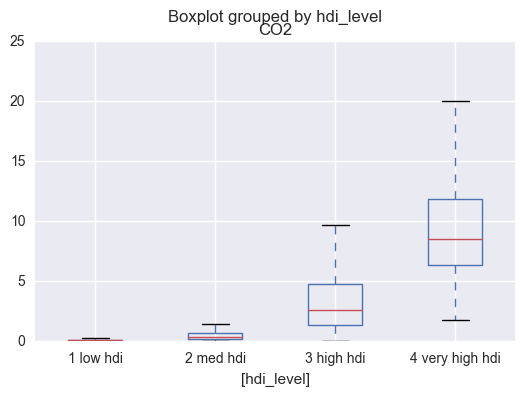

In [300]:
# look at the distributions by HDI level

# reshape so region, sub_region & CO2 are columns
df_box = df.sort_values('hdi_level').set_index(['hdi_level', 'country'])['CO2']
df_box.reset_index('country').boxplot(by='hdi_level', showfliers=False);

#.plot.box(by='hdi_level')
#df_box.head()
#.reset_index()['CO2']
#.boxplot(by='hdi_level', flierprops = flierprops);

#.set_index(['hdi_level','country', 'region','year'])['CO2'].reset_index()

#.\
#set_index(['hdi_level','region', 'sub_region','country','year'])['CO2'].reset_index(level=(0,1))
#df_box.head()
#df_box.boxplot(by='region', flierprops = flierprops);

In [313]:
# get the stats
df.groupby('hdi_level')['CO2'].describe()

,count,mean,std,min,25%,50%,75%,max
hdi_level,,,,,,,,
1 low hdi,281.0,0.128343,0.143251,0.014583,0.051909,0.082691,0.138864,1.335807
2 med hdi,723.0,0.606062,0.863193,0.003482,0.198344,0.367713,0.711975,10.519249
3 high hdi,1326.0,3.957474,4.337206,0.018141,1.382355,2.613913,4.788327,54.894402
4 very high hdi,953.0,11.475606,9.211538,1.738134,6.399220,8.520526,11.873369,68.619942


In [312]:
# compare energy buckets


query = 'year == 2008'
x = 'income'
y = 'CO2'
size = 'CO2_footprint'
cat_col = 'energy'

plot_bubble_with_cuts(df.query(query), cat_col)

In [314]:
# compare CO2 buckets
query = 'year == 2008'
x = 'income'
y = 'energy'
size = 'CO2_footprint'
cat_col = 'CO2'

plot_bubble_with_cuts(df.query(query), cat_col)

In [322]:
# compare sulfur buckets
query = 'year == 2008'
x = 'CO2'
y = 'energy'
size = 'CO2_footprint'
cat_col = 'energy'

plot_bubble_with_cuts(df.query(query), cat_col)

# Conclusions

# ==== OLD =====

# global view

In [226]:
# reshape df for plotting globally

def reshape_for_plot(df, val_name):
    df = df.reset_index()
    df = df.set_index(['region', 'sub_region', 'country'])
    df = df.sort_index(level = 0)

    t = df.T
    t = t.unstack(level = 1)
    df = pd.DataFrame(t)
    
    df = df.reset_index()
    df = df.rename(columns={'level_3': 'year', 0: val_name})

    return df

In [ ]:
#len(co2_long_multi_cat)
final_year = energy_long['year'].iloc[len(energy_long) -1]
#final_year = int(final_year)

In [ ]:
df = co2_long_multi_cat.loc[co2_long_multi_cat['year']==final_year]
plotly_group_scatter(df, group_col = 'region', x = 'energy p.c.', y = 'CO p.c.')

In [ ]:
co2_long_multi_cat.head()

In [ ]:
df2010 = co2_long_multi_cat.loc[co2_long_multi_cat['year'] == '2010']
df2010.head()

In [ ]:
#df2010 = df2010.reset_index()

In [ ]:
#df2010.dropna(inplace = True)

In [ ]:
df2010.head()

In [ ]:
#df2010.to_csv('data/df2010.csv')

In [ ]:
#test = pd.read_csv('data/df2010.csv')

In [ ]:
df2010.iplot(kind='bubble', x='CO p.c.', y='energy p.c.', size='CO p.c.', text='country',\
           xTitle='Carbon Emissions per capita', yTitle='Energy per capita', categories='region',\
             title='My Plot At Last')

## Add cars data

In [ ]:
cars = pd.read_csv('data/cars_regions.csv')
cars.head()

In [ ]:
# TODO: update reshape f'n to check for index type
type(cars.index)

In [ ]:
# reshape for plotting
cars.set_index('country', inplace=True)
cars.head()

In [ ]:
cars_long = reshape_for_plot(cars, 'cars p.1000')

In [ ]:
cars_long.head()

# Automate joining of DFs

In [ ]:
def join_df_slices(df_list, year):
    join_df_list = np.array()
    #for i, df in enumerate(df_list):
    for i, df in np.ndenumerate(df_list):
        if i==0:
            left_df = df[df['year']==year]
            left_df.set_index('country', inplace=True)
        else: 
            join_df = df[df['year']==year]
            join_df.set_index('country', inplace=True)
            join_df = join_df.iloc[:,[-1]]
            join_df_list.append(join_df)
     
    joined_df = left_df.join(join_df_list, how='outer', sort=False)
    joined_df.reset_index(inplace=True)
    joined_df.rename(columns={'index': 'country'}, inplace=True)
    joined_df.dropna(inplace=True)
    return joined_df
    

In [ ]:
df_list = np.array(co2_long, energy_long, cars_long)
year = '2007'

df2007 = join_df_slices(df_list, year)


In [ ]:
df2007.iplot(kind='bubble', x='CO p.c.', y='cars p.1000', size='CO p.c.', text='country',\
           xTitle='Carbon Emissions per capita', yTitle='Cars per 1000 population', categories='region',\
             title='Carbon Emissions vs Car Ownership for ' + year)

In [ ]:
#df_list = [cars_long, co2_long, energy_long]
#year = '2007'

cars2007 = cars_long[cars_long['year']=='2007']
co2007 = co2_long[co2_long['year']=='2007']
energy2007 = energy_long[energy_long['year']=='2007']

In [ ]:
df = pd.merge_ordered(co2007, energy2007, left_by='country', how = 'left')

In [ ]:
df2007 = pd.merge_ordered(df, cars2007, left_by='country', how='left')
df2007.head()

In [ ]:
df2007.head()

In [ ]:
df2007.iplot(kind='bubble', x='CO p.c.', y='cars p.1000', size='CO p.c.', text='country',\
           xTitle='Carbon Emissions per capita', yTitle='Cars per 1000 population', categories='region',\
             title='Carbon Emissions vs Car Ownership - 2007')

## Add population data

In [ ]:
pop = pd.read_csv('data/cleaned/pop_regions.csv')
pop.head()

In [ ]:
pop.set_index('country', inplace = True)
pop_long = reshape_for_plot(pop, 'total pop')
pop_long.head()

In [ ]:
df_list = [co2_long, energy_long, cars_long, pop_long]
year = '2007'

df2007 = join_df_slices(df_list, year)

In [ ]:
for region in df2007['region'].unique():
    print('\n')
    print(region)
    print(df2007[df2007['region']==region].corr())

In [ ]:
for region in df2007['region'].unique():
    print '\n'
    print region
    df = df2007[df2007['region']==region]
    for subreg in df['sub_region'].unique():
        print '\n'
        print subreg
        print df[df['sub_region']==subreg].corr()

In [ ]:
df = df2007[df2007['region']=='Europe']

In [ ]:
for subreg in df['sub_region'].unique():
    print  
    print subreg
    print df[df['sub_region']==subreg].corr()

In [ ]:
#for region in df2007['region'].unique():

df2007.iplot(kind='bubble', x='CO p.c.', y='energy p.c.', size='total pop', text='country',\
       xTitle='Carbon Emissions per capita', yTitle='Energy Consumption per capita', categories='region',\
         title='Carbon vs Energy Consumption per capita - ' + year)

In [ ]:
for region in df2007['region'].unique():

    df2007[df2007['region']==region].iplot(kind='bubble', x='energy p.c.', y='cars p.1000', size='total pop', text='country',\
           xTitle='Energy Consumption per capita', yTitle='Cars per 1000 population', categories='sub_region',\
             title=region + ' 2007')

# How important is EU membership?

In [ ]:
eu = pd.read_csv('data/EU_countries.csv')
eu.rename(columns = {'Countries': 'country'}, inplace = True)
eu

In [ ]:
eu_members = list(eu['country'])

In [ ]:
# Compare EU vs non-EU member countries
    
def plotly_eu(df, index, column, value, eu_list):
    q = 'country in @eu_members'
    n = 'country not in @eu_members'

    eu = df.query(q)
    not_eu = df.query(n)
    
    eu = eu.pivot(index, column, value)
    not_eu= not_eu.pivot(index, column, value)

    fig1 = plotly_line(eu, q)
    fig2 = plotly_line(not_eu, n)
    
    py.offline.iplot(fig1)
    py.offline.iplot(fig2)
    


In [ ]:
plotly_eu(energy_eur, 'year', 'country', 'value', eu_members)

In [ ]:
df.head()

In [ ]:

plotly_eu(df, 'year', 'country', 'value', eu_list)

In [ ]:
fig = eu.iplot(asFigure = True,\
                            title = sub,\
                            yTitle = 'Metric tons per person',\
                            theme = 'ggplot')
py.offline.iplot(fig)

## testing multi-index

In [ ]:
len(co2_regions)

In [ ]:
#co2_regions = co2_regions.drop(['level_0', 'index'], axis = 1)

In [ ]:
#arrays = [[1, 1, 2, 2], ['red', 'blue', 'red', 'blue']]
idx = pd.MultiIndex.from_arrays(arrays)
test = pd.Series(np.random.randn(len(co2_regions)), index = idx )



In [ ]:
len(idx)

In [ ]:
test_sorted = test.sort_index(level = 0, ascending = False)
pd.DataFrame(test_sorted)

In [ ]:

test = pd.DataFrame(co2_regions.loc[['1751' : '2012'], index = arrays)
test.head()

In [ ]:
# plot a tidy/long df of co2_regions

import seaborn as sns

sns.set(color_codes = True)
#sns.set_style({'axes.linewidth': '0.5'})


co2_regions.year = pd.Categorical(co2_regions.year, ordered = True)

#p = sns.factorplot(x = 'year', y = 'value', hue = 'country', 
#               col = 'sub_region', sharey = False, 
#                   data = co2_regions[co2_regions.region == 'Europe'])

#p.set_xticklabels(rotation=45)
#p.set(ylim=(0,None))

eur_subreg = co2_regions[co2_regions.region == 'Europe']['sub_region'].unique()


co2_regions.loc[co2_regions['sub_region'].isin(eur_subreg)].country.unique()

np.arange(int(co2_regions.year.min()), int(co2_regions.year.max()), 10.)

eur_subreg

co2_regions[co2_regions['sub_region'].isin(eur_subreg)].groupby(['sub_region', 'country']).sum()

In [ ]:
# get a better legend?

for subreg in eur_subreg:
    df = co2_regions[co2_regions['sub_region'] == subreg]
    fignum = pd.Index(eur_subreg).get_loc(subreg)
    plt.figure(fignum)
    
    ax = sns.pointplot(x = 'year', y = 'value', hue = 'country', 
                   col = subreg, data = df, scale = .5)
    ax.legend(loc = 0)
    ax.set(ylim=(0,None))
    ax.set(xlim=(1950,None))
    #plt.xticks(np.arange(int(co2_regions.year.min()), int(co2_regions.year.max()), 10.))
    #ax.set_xticklabels(rotation=45)
    plt.title(subreg)
    

# which countries had no corresponding regional info
co2_totals = co2_regions[co2_regions.region.isnull()].groupby('country').sum()
co2_totals

In [ ]:
def remove_special_char(s):
    clean_s = re.sub('\W+',' ', s)
    return clean_s
    

names_cleaned = regions['name'].apply(remove_special_char)
names_cleaned_list = names_cleaned.str.split()
connector_words = ['and', 'et', 'of', 'the']

for l in names_cleaned_list:
    new_list = []
    for word in l:
        if word in connector_words:
            l.remove(word)
        else:
            pass
    new_list.append(l)
    print l
       


In [ ]:
import seaborn as sns

sns.set(color_codes = True)
#sns.set_style({'axes.linewidth': '0.5'})


co2_my_countries_long.year = pd.Categorical(co2_my_countries_long.year, ordered = True)



p = sns.factorplot(x = 'year', y = 'value', hue = 'country', 
               row = 'region', size = 6, data = co2_my_countries_long)

p.set_xticklabels(rotation=45)
p.set(ylim=(0,None))


co2_my_countries_long.groupby(['sub_region', 'country']).describe()

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!